# Постановка задачи выбора локации для скважины

**Дано:** <br> 
Пробы нефти в трёх регионах, характеристики для каждой скважины в регионе.<br>

**Надо:** 
1. Построить модель для определения региона, где добыча принесёт наибольшую прибыль. 
2. Проанализировать возможную прибыль и риски техникой Bootstrap.

In [2]:
import pandas as pd
import numpy as np
import random
import os

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from pandas.plotting import scatter_matrix

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split

%matplotlib inline

# Этап 1. Загрузка, анализ и преподготовка данных.

In [3]:
path_review_0 = '/datasets/geo_data_0.csv'
path_review_1 = '/datasets/geo_data_1.csv'
path_review_2 = '/datasets/geo_data_2.csv'
paths_review = [path_review_0, path_review_1, path_review_0]

my_path_0 = '/Users/Ideapad S145/Desktop/Data_Science/07.Модуль Бизнес метрики/Практика/geo_data_0.csv'
my_path_1 = '/Users/Ideapad S145/Desktop/Data_Science/07.Модуль Бизнес метрики/Практика/geo_data_1.csv'
my_path_2 = '/Users/Ideapad S145/Desktop/Data_Science/07.Модуль Бизнес метрики/Практика/geo_data_2.csv'
my_paths = [my_path_0, my_path_1, my_path_2]

df = []
for path_review, my_path in zip(paths_review, my_paths):
    if os.path.exists(path_review):
        df.append(pd.read_csv(path_review, sep=','))
    elif os.path.exists(my_path):
        df.append(pd.read_csv(my_path, sep=','))
    else:
        print("Проверьте правильность пути к датасету")

In [4]:
df

[          id        f0        f1        f2     product
 0      txEyH  0.705745 -0.497823  1.221170  105.280062
 1      2acmU  1.334711 -0.340164  4.365080   73.037750
 2      409Wp  1.022732  0.151990  1.419926   85.265647
 3      iJLyR -0.032172  0.139033  2.978566  168.620776
 4      Xdl7t  1.988431  0.155413  4.751769  154.036647
 ...      ...       ...       ...       ...         ...
 99995  DLsed  0.971957  0.370953  6.075346  110.744026
 99996  QKivN  1.392429 -0.382606  1.273912  122.346843
 99997  3rnvd  1.029585  0.018787 -1.348308   64.375443
 99998  7kl59  0.998163 -0.528582  1.583869   74.040764
 99999  1CWhH  1.764754 -0.266417  5.722849  149.633246
 
 [100000 rows x 5 columns],
           id         f0         f1        f2     product
 0      kBEdx -15.001348  -8.276000 -0.005876    3.179103
 1      62mP7  14.272088  -3.475083  0.999183   26.953261
 2      vyE1P   6.263187  -5.948386  5.001160  134.766305
 3      KcrkZ -13.081196 -11.506057  4.999415  137.945408
 4      

У нас получился список из трех датасетов.<br>
Сделаем анализ и преподготовку данных по каждому датасету отдельно.<br>
Что будем смотреть:
- заполненность данных у признаков;
- распределение данных у признаков.

**Посмотрим первый датасет**

In [5]:
display(df[0].info())
display(df[0].head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647


Заполненность данными 100%<br>

Проверим уникальность значений в столбце id

In [6]:
# Функция анализа уникальности id
def unique_id(dataset):
    print('Количество уникальных id = ', len(dataset.id.unique()))
    print('Количество дубликатов = ', len(dataset) - len(dataset.dropna()))

In [7]:
unique_id(df[0])

Количество уникальных id =  99990
Количество дубликатов =  0


Уникальных id 99_990, а всего строк в датасете 100_000 и приэтом нет полных дупликатов записей датасета. Т.е. в датасете 10 записей с неуникальными id, но с разными значениями признаков.<br>
Найдем их и посмотрим что у них в признаках.

In [8]:
# сделаем функцию, которая ищет дубликаты id, если они есть.
def searh_duplicates_id(dataset):
    return list(dataset[dataset.id.duplicated()].id)

Посмтрим на эти дубликаты.

In [9]:
df[0][df[0].id.isin(searh_duplicates_id(df[0]))]

,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
1364,bxg6G,0.411645,0.856830,-3.653440,73.604260
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
16633,fiKDv,0.157341,1.028359,5.585586,95.817889
21426,Tdehs,0.829407,0.298807,-0.049563,96.035308
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205


Значения признаков разные, а значения id повторяются.<br>
У нас нет возможности выяснить причину данной аномалии в данных, потому что не возможности задать вопрос тому, кто делал датасет или у представителей бизнеса или аналитика.<br>
В связи с этим для формирования обучающей и валидационной выборок я предлагаю их удалить тем более их всего 0,01% в датасете.<br>
Перед тем как удалить посмотрим статистическое описание данного датасета. Может в значениях признаков у дублирующихся id будут какие-то аномалии относительно всего набора значений признаков датасета. 

In [10]:
df[0].describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


Значения признаков у дублирующих id обычные поэтому удалим их.

In [11]:
df[0] = df[0][~df[0].id.isin(searh_duplicates_id(df[0]))]

Посмотрим распреление значений в признаках.

In [12]:
# напишем функцию, которая строила бы гистограмму распределения и ящик с усами
def distribution_feature(feature):
    fig = plt.figure(figsize=(12,4))
    ax_1 = fig.add_subplot(1, 2, 1)
    ax_2 = fig.add_subplot(1, 2, 2)
    sns.histplot(x=feature, kde=True, ax=ax_1)
    ax_2 = sns.boxplot(x=feature, ax=ax_2)
    ax_1.set_title(f'Гистограмма распределения признака {feature.name}', fontsize=12)
    ax_2.set_title(f'Ящик с усами {feature.name}', fontsize=12)

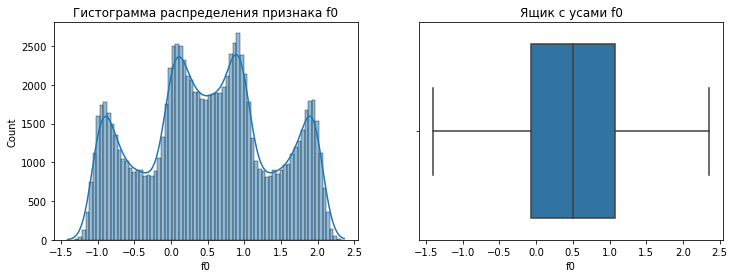

In [13]:
distribution_feature(df[0].f0)

Интересное распределение признака f0. У данного распределения есть четыре ярко выраженные моды симметричные относительно среднего значения (0.5). 
Я думаю это интегралльный признак, который зависит от четырех других независимых между собой признаков с нормальным распределением у каждого и с небольшой дисперсией. 
Статистических выбросов нет.<br>

Перейдем к следующему признаку.

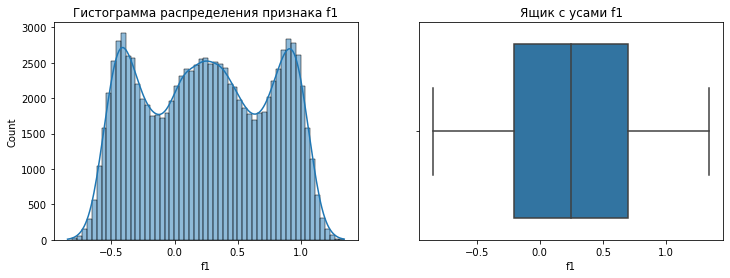

In [14]:
distribution_feature(df[0].f1)

Распределение признака f1 приницпиально похоже на распределение признака f1, только с тремя модами. Т.е. это тоже интегральный признак, но уже от трех независимых признаков с нормальным распределением каждый.<br>
Статистических выбросов нет.<br>

Перейдем к следующему признаку.

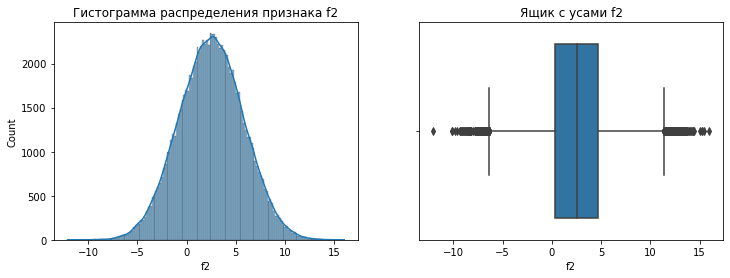

In [15]:
distribution_feature(df[0].f2)

Распределение данного признака похоже на почти идеальное нормальное распределение.<br>
Длиные хвосты справа и слева образуют небольшое количество статистичеких выбросов.


Перейдем к целевому признаку.

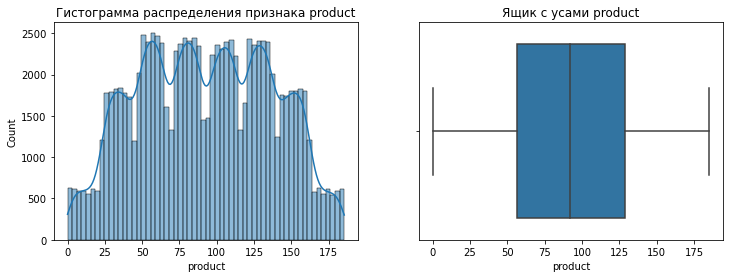

In [16]:
distribution_feature(df[0]['product'])

Я вижу линейную зависимость целевого признака от 6 признаков распределение которых либо равномерное либо нормальное с маленькой дисперсией. <br>
Статистических выбросов нет.

Посмотрим попарную корреляцию признаков

In [17]:
df[0][['f0', 'f1', 'f2', 'product']].corr()

,f0,f1,f2,product
f0,1.000000,-0.440724,-0.003204,0.143504
f1,-0.440724,1.000000,0.001783,-0.192338
f2,-0.003204,0.001783,1.000000,0.483628
product,0.143504,-0.192338,0.483628,1.000000


array([[<AxesSubplot:xlabel='f0', ylabel='f0'>,
        <AxesSubplot:xlabel='f1', ylabel='f0'>,
        <AxesSubplot:xlabel='f2', ylabel='f0'>,
        <AxesSubplot:xlabel='product', ylabel='f0'>],
       [<AxesSubplot:xlabel='f0', ylabel='f1'>,
        <AxesSubplot:xlabel='f1', ylabel='f1'>,
        <AxesSubplot:xlabel='f2', ylabel='f1'>,
        <AxesSubplot:xlabel='product', ylabel='f1'>],
       [<AxesSubplot:xlabel='f0', ylabel='f2'>,
        <AxesSubplot:xlabel='f1', ylabel='f2'>,
        <AxesSubplot:xlabel='f2', ylabel='f2'>,
        <AxesSubplot:xlabel='product', ylabel='f2'>],
       [<AxesSubplot:xlabel='f0', ylabel='product'>,
        <AxesSubplot:xlabel='f1', ylabel='product'>,
        <AxesSubplot:xlabel='f2', ylabel='product'>,
        <AxesSubplot:xlabel='product', ylabel='product'>]], dtype=object)

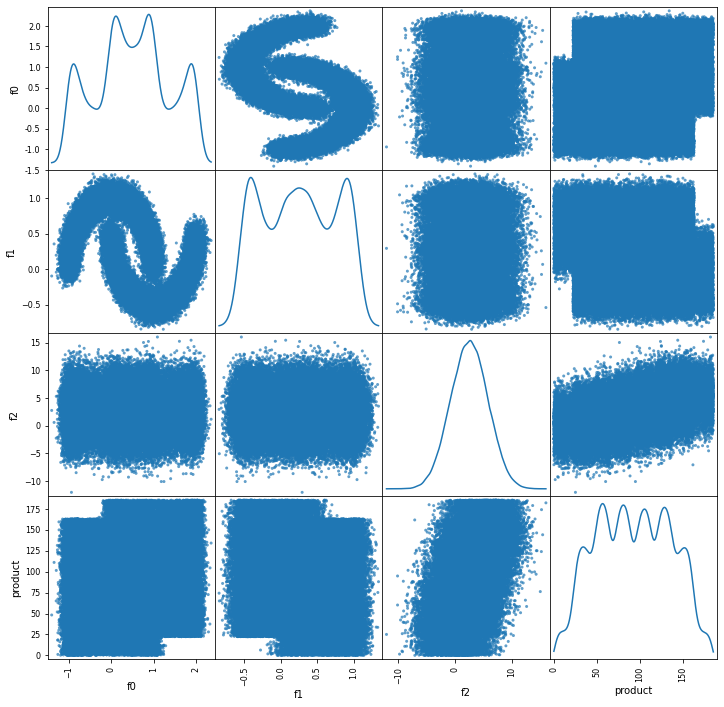

In [18]:
scatter_matrix(df[0][['f0', 'f1', 'f2', 'product']], alpha=0.7, figsize=(12,12 ), diagonal="kde")

Наблюдаются умеренно отрицательная коррелялиция между признаками f0 и f1 <br>
и умеренно положительная коррелялиция между признаками product и  f2.<br>
Фигура на графике коррелляции между f0 и f1 говорит о наличии нелинейной функциональной зависимости между этими двуми признаками. Наблюдается линейная зависимость  между целевым признаком и f2. Также наблюдаются довольно нетривиальные функциональные зависимости (пересечение двух прямоугольников на графике) между признаками f1 и product, а также f0 и product несмотря на то, что корреляции между этими признаками несущественна

**Посмотрим второй датасет**

In [19]:
display(df[1].info())
display(df[1].head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305


Такой же по длине датасет как и первый.
Все значения заполненны.

Также проверим уникальность значений поля id

In [20]:
unique_id(df[1])

Количество уникальных id =  99996
Количество дубликатов =  0


У нас 4 повторяющихся id с разными значениями признаков. Посмотрим на них.

In [21]:
df[1][df[1].id.isin(searh_duplicates_id(df[1]))]

,id,f0,f1,f2,product
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


Ничего особенного в них нет и поэтому их тоже удалим.

In [22]:
df[1] = df[1][~df[1].id.isin(searh_duplicates_id(df[1]))]

Посмотрим статистическое описание данного датасета

In [23]:
df[1].describe()

,f0,f1,f2,product
count,99992.000000,99992.000000,99992.000000,99992.000000
mean,1.141363,-4.796522,2.494511,68.824148
std,8.965805,5.119934,1.703587,45.944889
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298525,-8.267985,1.000021,26.953261
50%,1.153190,-4.813005,2.011475,57.085625
75%,8.620964,-1.332704,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


Ярко выраженных аномалий не наблюдается.<br>

Посмотрим гистограммы распределений значений принаков и целевого признака. 

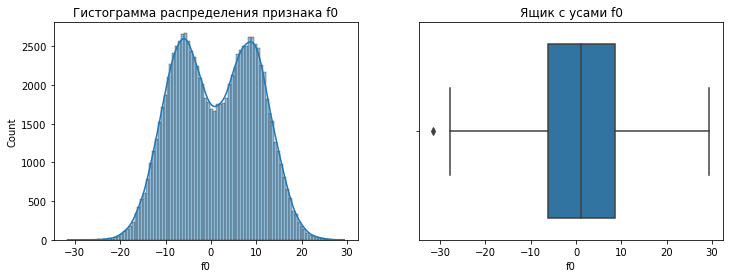

In [24]:
distribution_feature(df[1].f0)

Почти идеально бимодальное распределение, что говорит нам, что данный признак получен путем линейной комбинации двух признаков с нормальным распределением.

Перейдем к следующему признаку.

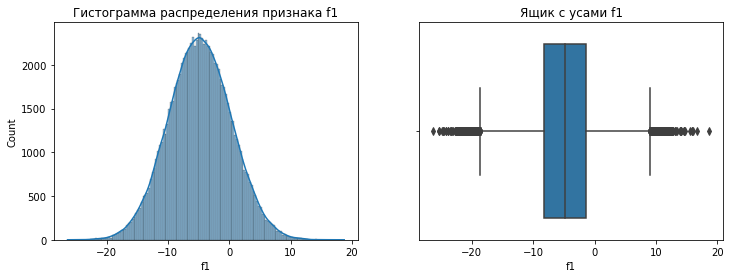

In [25]:
distribution_feature(df[1].f1)

Распределение данного признака похоже на идеальное нормальное распределение.<br>
Длиные хвосты справа и слева образуют небольшое количество статистичеких выбросов.

Перейдем к следующему признаку.

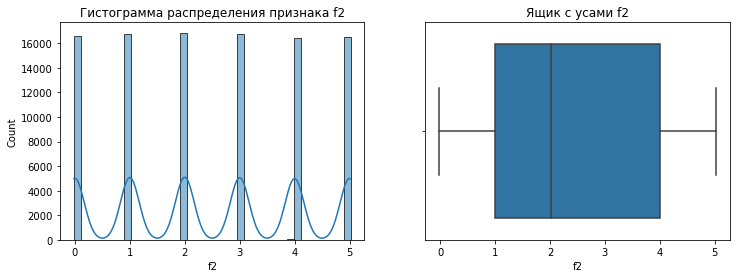

In [26]:
distribution_feature(df[1].f2)

Это похоже на категориальный признак выраженный числовыми значениям, причем распределение объектов по категориям равномерное. Посмотрим уникальные значения этого признака.

In [27]:
df[1].f2.unique()

array([-5.87601369e-03,  9.99182737e-01,  5.00116016e+00, ...,
        4.99865060e+00,  1.00014635e+00, -3.29851829e-03])

Очевидно, что если сделать округление до целого, то получим целые числа от 0 до 5

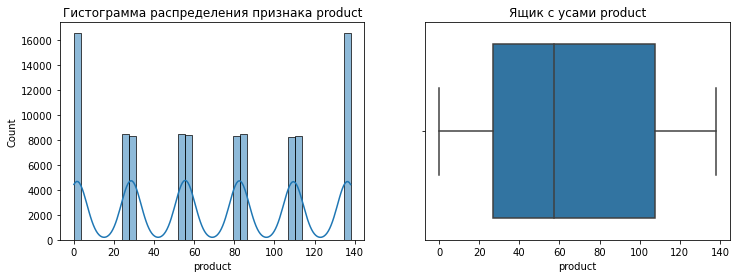

In [28]:
distribution_feature(df[1]['product'])

Очевидно что наш целевой признак тоже де факто категориальный выраженный числовыми значениям, причем распределение объектов по категориям равномерное. Т.е. фактически для данного датасета решить вопрос классификации при условии, что в постановке задачи четко было указано делать модель линейной регрессии. <br>
Получается по факту мы видим разницу, которая возможно обусловлена ошибкой измерения.

Так и оставим пока.

Посмотрим на корреляцию признаков второго датасета

In [29]:
df[1][['f0', 'f1', 'f2', 'product']].corr()

,f0,f1,f2,product
f0,1.000000,0.182263,-0.001821,-0.030534
f1,0.182263,1.000000,-0.002608,-0.010167
f2,-0.001821,-0.002608,1.000000,0.999397
product,-0.030534,-0.010167,0.999397,1.000000


array([[<AxesSubplot:xlabel='f0', ylabel='f0'>,
        <AxesSubplot:xlabel='f1', ylabel='f0'>,
        <AxesSubplot:xlabel='f2', ylabel='f0'>,
        <AxesSubplot:xlabel='product', ylabel='f0'>],
       [<AxesSubplot:xlabel='f0', ylabel='f1'>,
        <AxesSubplot:xlabel='f1', ylabel='f1'>,
        <AxesSubplot:xlabel='f2', ylabel='f1'>,
        <AxesSubplot:xlabel='product', ylabel='f1'>],
       [<AxesSubplot:xlabel='f0', ylabel='f2'>,
        <AxesSubplot:xlabel='f1', ylabel='f2'>,
        <AxesSubplot:xlabel='f2', ylabel='f2'>,
        <AxesSubplot:xlabel='product', ylabel='f2'>],
       [<AxesSubplot:xlabel='f0', ylabel='product'>,
        <AxesSubplot:xlabel='f1', ylabel='product'>,
        <AxesSubplot:xlabel='f2', ylabel='product'>,
        <AxesSubplot:xlabel='product', ylabel='product'>]], dtype=object)

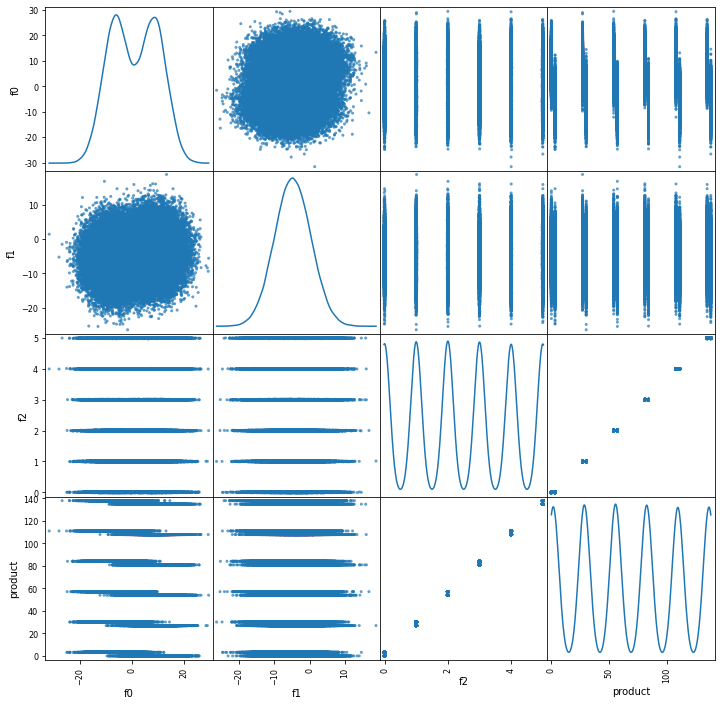

In [30]:
scatter_matrix(df[1][['f0', 'f1', 'f2', 'product']], alpha=0.7, figsize=(12,12 ), diagonal="kde")

Очевидная почти 100% корреляция признака f2  с целевым признаком. Вся модель для этого датасета сведется к поиску коэффициента линейной зависимости product = alfha * f2.

**Посмотрим третий датасет**

In [31]:
display(df[2].info())
display(df[2].head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910


Все тоже самое, то и в первых двух датасетах<br>

проверим уникальность значений в поле id

In [32]:
unique_id(df[2])

Количество уникальных id =  99996
Количество дубликатов =  0


Тоже есть неуникальность в значениях и поэтому повторим процедуру удаления.

In [33]:
df[2] = df[2][~df[2].id.isin(searh_duplicates_id(df[2]))]

Посмотрим статистическое описание датасета

In [34]:
df[2].describe()

,f0,f1,f2,product
count,99992.000000,99992.000000,99992.000000,99992.000000
mean,0.001975,-0.002113,2.495088,94.998767
std,1.732061,1.730404,3.473491,44.747763
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162328,-1.174820,0.130269,59.450441
50%,0.009411,-0.009580,2.484236,94.925026
75%,1.158442,1.163592,4.858662,130.585544
max,7.238262,7.844801,16.739402,190.029838


Ярко выраженных аномалий не наблюдается.<br>

Посмотрим гистограммы распределений значений принаков и целевого признака. 

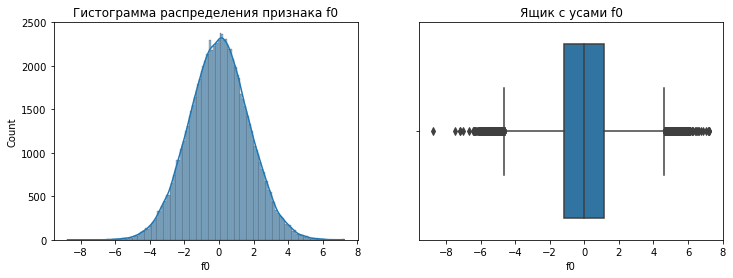

In [35]:
distribution_feature(df[2].f0)

Распределение данного признака похоже на идеальное нормальное распределение.<br>
Длиные хвосты справа и слева образуют небольшое количество статистичеких выбросов.

Перейдем к следующему признаку.

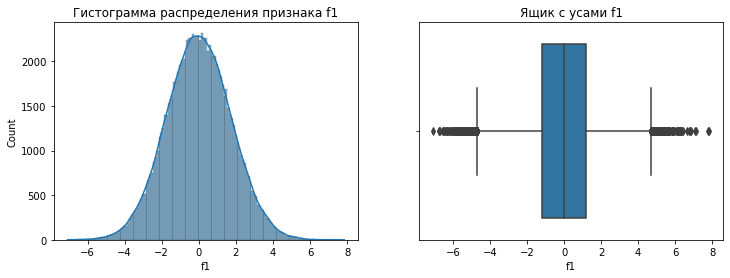

In [36]:
distribution_feature(df[2].f1)

Идентичная картина как у признака f0. 

Перейдем к следующему признаку.

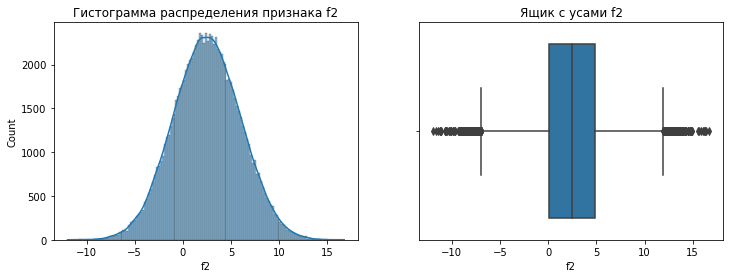

In [37]:
distribution_feature(df[2].f2)

Идентичная картина как у предыдущих признаков.

Перейдем к целевому признаку третьего датасета.

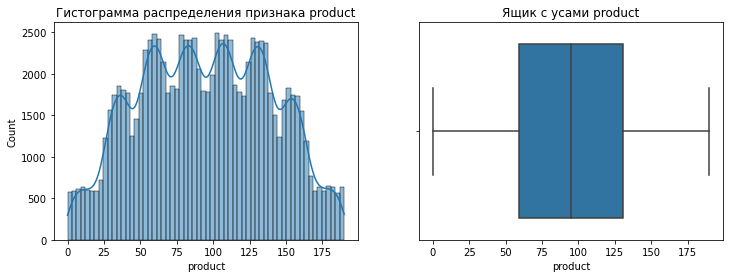

In [38]:
distribution_feature(df[2]['product'])

Также как и у первого датасета я вижу линейную зависимость целевого признака от 6 признаков распределение которых либо равномерное либо нормальное с маленькой дисперсией. <br>
Статистических выбросов нет.

Посмотрим корреляцию признаков третьего датасета

In [39]:
df[2][['f0', 'f1', 'f2', 'product']].corr()

,f0,f1,f2,product
f0,1.000000,0.000501,-0.000454,-0.001974
f1,0.000501,1.000000,0.000763,-0.001046
f2,-0.000454,0.000763,1.000000,0.445873
product,-0.001974,-0.001046,0.445873,1.000000


array([[<AxesSubplot:xlabel='f0', ylabel='f0'>,
        <AxesSubplot:xlabel='f1', ylabel='f0'>,
        <AxesSubplot:xlabel='f2', ylabel='f0'>,
        <AxesSubplot:xlabel='product', ylabel='f0'>],
       [<AxesSubplot:xlabel='f0', ylabel='f1'>,
        <AxesSubplot:xlabel='f1', ylabel='f1'>,
        <AxesSubplot:xlabel='f2', ylabel='f1'>,
        <AxesSubplot:xlabel='product', ylabel='f1'>],
       [<AxesSubplot:xlabel='f0', ylabel='f2'>,
        <AxesSubplot:xlabel='f1', ylabel='f2'>,
        <AxesSubplot:xlabel='f2', ylabel='f2'>,
        <AxesSubplot:xlabel='product', ylabel='f2'>],
       [<AxesSubplot:xlabel='f0', ylabel='product'>,
        <AxesSubplot:xlabel='f1', ylabel='product'>,
        <AxesSubplot:xlabel='f2', ylabel='product'>,
        <AxesSubplot:xlabel='product', ylabel='product'>]], dtype=object)

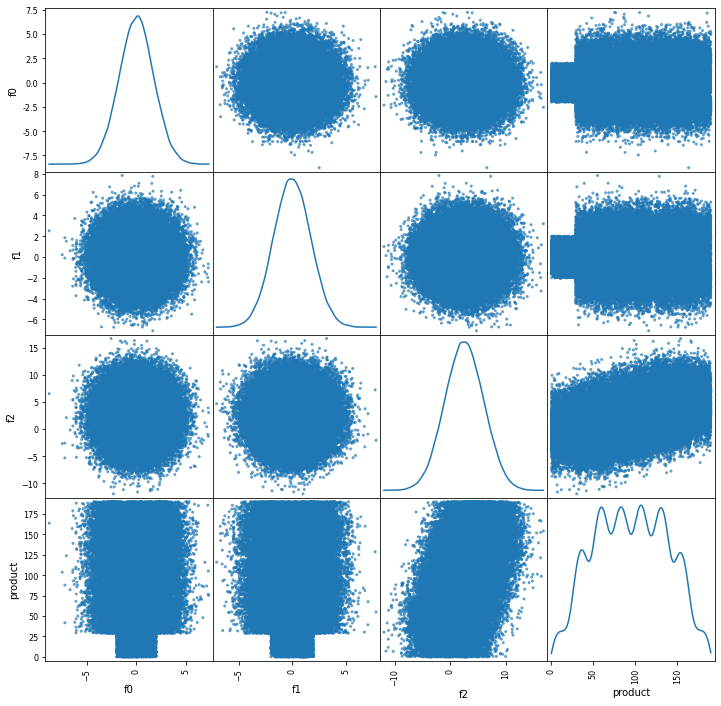

In [40]:
scatter_matrix(df[2][['f0', 'f1', 'f2', 'product']], alpha=0.7, figsize=(12,12 ), diagonal="kde")

Наблюдается умеренная положительная корреляция f2 и product, а также нетривиальная нелинейная зависимость между признаками f0 и product, а также f1 и product. Вероятно существенной функциональной связи между признаками f0 и product, а также f1 и product нет и рисунок на графике это случайное стечении обстоятельств.

**Общее резюме после анализа данных трех датасетов.**<br>
Целевые признаки всех трех датасетов имеют четкое кучкование на 6 групп (мод). Это нам говорит, что есть шесть ярко выраженных профилей скважин. В первом и в третьем датасете распределение 6 целевых признаков размыто (объекты нормально распределены вокруг каждой своей моды), а во втором датасете ярко выраженная классификация скважин на 6 категорий.<br>
Практически все признаки распределены нормально либо являются линейной комбинацией скрытых признаков, которые также распределены нормально.<br>

В рамках предобработки были удалены дубликаты id, а также удалены статистические выбросы для некоторых признаков.<br>

В первом датасете есть умеренные корреляции признаков f0 и f1 (отрицательная) и между признаками product (целевой признак!) и  f2 (положительная). При этом судя по графику зависимость между признаками f0 и f1 явная и она нелинейная. Зависимость между признакми product и f2 линейная. Слегка угадываются нелинейная зависимость между признаками f1 и product, а также f0 и product пересечение двух прямоугольников - вероятно это ложная зависимость. Данные аномалии на графиках рассматривать не будем.<br>

Во втором датасете наблюдается практически линейная зависимость между целевым признаком и f2. <br>

В третьем датасете наблюдается умеренная положительная корреляция между признаками f2 и product. Возможность нелинейной зависимости признаков f0 и product, а также f1 и product рассматривать не будем.

# Этап 2. Обучение модели для каждого региона.

Из наших исходных датасетов создадим три датасета для обучения моделей - для каждого региона свой датасет.

In [41]:
# Удалим столбец id
region_0 = df[0].drop('id', axis=1)
region_1 = df[1].drop('id', axis=1)
region_2 = df[2].drop('id', axis=1)

Сделаем группы целевых признаков длиной "10.0" для стратификации разбиения 

In [42]:
region_0['target_groups'] = df[0]['product'].apply(lambda x: round(x/10))
region_1['target_groups'] = df[1]['product'].apply(lambda x: round(x/10))
region_2['target_groups'] = df[2]['product'].apply(lambda x: round(x/10))

**Разбейте данные на обучающую и валидационную выборки в соотношении 75:25.**

Напишием функцию разделение исходного датасета на тренировочную и валидационную выборки в соотновшении 0,75:0,25 и стратификацией по целевому признаку.

In [43]:
def dataset_selection(dataset):
    target = dataset['product']
    features = dataset.drop('product', axis=1)
    return train_test_split(features, target, test_size=0.25,  random_state=12345, stratify=dataset.target_groups)

In [44]:
region_0_features_train, region_0_features_valid, region_0_target_train, region_0_target_valid = dataset_selection(region_0)
region_1_features_train, region_1_features_valid, region_1_target_train, region_1_target_valid = dataset_selection(region_1)
region_2_features_train, region_2_features_valid, region_2_target_train, region_2_target_valid = dataset_selection(region_2)

Удалим уже не нужное нам поле "target_groups"

In [45]:
region_0_features_train.drop('target_groups', axis=1, inplace=True)
region_0_features_valid.drop('target_groups', axis=1, inplace=True)
region_1_features_train.drop('target_groups', axis=1, inplace=True)
region_1_features_valid.drop('target_groups', axis=1, inplace=True)
region_2_features_train.drop('target_groups', axis=1, inplace=True)
region_2_features_valid.drop('target_groups', axis=1, inplace=True)

Посмотрим размеры выборок, полученных при нашем разбиении

In [46]:
print('размер обучающей выборки региона 0 =', region_0_features_train.shape)
print('размер валидационной выборки региона 0 =', region_0_features_valid.shape)
print()
print('размер обучающей выборки региона 1 =', region_1_features_train.shape)
print('размер валидационной выборки региона 1 =', region_1_features_valid.shape)
print()
print('размер обучающей выборки региона 2 =', region_2_features_train.shape)
print('размер валидационной выборки региона 2 =', region_2_features_valid.shape)

размер обучающей выборки региона 0 = (74985, 3)
размер валидационной выборки региона 0 = (24995, 3)

размер обучающей выборки региона 1 = (74994, 3)
размер валидационной выборки региона 1 = (24998, 3)

размер обучающей выборки региона 2 = (74994, 3)
размер валидационной выборки региона 2 = (24998, 3)


**Обучите модель и сделайте предсказания на валидационной выборке**

Сделаем масштабирование признаков наших датасетов.<br>
Напишем функцию для масштабирования данных. На входе исходный датасет, а на выходе трансформированный датасет. 

In [47]:
def scaler_data(features_train, features_valid, numeric):
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])
    return scaler.transform(features_train[numeric]), scaler.transform(features_valid[numeric])

Нормализуем данные датасета первого региона.

In [48]:
numeric = ['f0', 'f1', 'f2']
region_0_features_train[numeric], region_0_features_valid[numeric] = scaler_data(region_0_features_train, 
                                                                                 region_0_features_valid, 
                                                                                 numeric)

region_1_features_train[numeric], region_1_features_valid[numeric] = scaler_data(region_1_features_train, 
                                                                                 region_1_features_valid, 
                                                                                 numeric)

region_2_features_train[numeric], region_2_features_valid[numeric] = scaler_data(region_2_features_train, 
                                                                                 region_2_features_valid, 
                                                                                 numeric)

В качестве типа модели будем использовать линейную регрессию.<br>
В качестве метрики качества модели будем использовать коэффициент детерминации и RMSE.<br>
Напишем функцию, которая строит модель линейной регрессии и расчитывает метрики качества модели.

In [49]:
def LG_model(features_train, features_valid, target_train, target_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)

    return [model.score(features_train, target_train), 
            model.score(features_valid, target_valid), 
            mean_squared_error(target_train, model.predict(features_train))**0.5,
            mean_squared_error(target_valid, model.predict(features_valid))**0.5,
            model.predict(features_valid),
            target_valid,
            model.predict(features_valid).mean(),
            target_valid.mean()]

Сведем результаты работы трех моделей линейной регрессии в одну таблицу.
В этой же таблице хранятся истинные и предсказанные модели валидационной выборке, но на экран мы их сейчас не будем выводить, а будем использовать дальше в расчете экономических метрик.

In [50]:
result = pd.DataFrame(data=[LG_model(region_0_features_train, region_0_features_valid, region_0_target_train, region_0_target_valid),
                            LG_model(region_1_features_train, region_1_features_valid, region_1_target_train, region_1_target_valid),
                            LG_model(region_2_features_train, region_2_features_valid, region_2_target_train, region_2_target_valid)],
                     columns=['R2_train', 'R2_valid', 'RMSE_train', 'RMSE_valid', 'Predict_valid', 'Target_valid', 'Predict_valid_mean', 'Target_valid_mean'],
                     index=['Region_0', 'Region_1', 'Region_2'])
# Результаты predict_valid и target_valid
display(result[['R2_train', 'R2_valid', 'RMSE_train', 'RMSE_valid', 'Predict_valid_mean', 'Target_valid_mean']])

,R2_train,R2_valid,RMSE_train,RMSE_valid,Predict_valid_mean,Target_valid_mean
Region_0,0.278162,0.268202,37.624039,37.899665,92.580172,92.458534
Region_1,0.999623,0.999628,0.891559,0.886925,68.815073,68.808710
Region_2,0.199517,0.196642,40.037639,40.100854,94.874227,94.999651


**Резюме:**<br>

Модель для региона 2 получилась очень точной. Это связано с тем, что целевой признак product линейно зависит от признака f2. Средние предсказанные значения и средние истинные значения на валидационной выборке ожидаемо практически идентичны.<br>
 
Модель для региона 0 получилась заметно хуже по метрикам. Коэффициент детерминации как на обучающей так и  на валидационной получился 0,27, а стандартное отклонение составило 37,6 и 37,9 соответственно. Несмотря на то, что метрики качества получились не очень хорошими они получились почти одинаковыми на обучающей и валидационной выборках. Это может говорить о том, что полученная модель работает скорее всего стабильно и с прогнозируемым стандартным отклонением. Довольно большое значение RMSE скорее всего говорит о том, что есть выбросы (длинные хвосты в нормальном распределении признаков). В итоге стабильность модели и нормальное распределение признаков (скрытых признаков) говорит о том, что на большинстве объектов (ближе к модальным пикам) модель работает хорошо, что подтверждается фактом совпадения среднего предсказанных значений и  среднего фактических значений на валидационной выборке. <br>

Модель для региона 2 получилась самой худшей по метрикам из нашего набора. Но несмотря на это она также работает стабильно одинаковые результаты как на обучающей выборке, так и на валидационной выборке. Также как и для модели региона 0 среднее предсказанных значений и среднее фактических значений на валидационной выборке совпадают. Обяснение этому факту такое же как для модели региона 0.<br>

**В итоге все модели можно признать неплохими и использовать для расчета экономических показателей (метрик) на их основе.**

# Этап 3. Расчёт прибыли. 

**Все ключевые значения для расчётов сохраните в отдельных переменных**

Все ключевые значения для расчетов находятся в таблице result

In [51]:
display(result.transpose())

,Region_0,Region_1,Region_2
R2_train,0.278162,0.999623,0.199517
R2_valid,0.268202,0.999628,0.196642
RMSE_train,37.624039,0.891559,40.037639
RMSE_valid,37.899665,0.886925,40.100854
Predict_valid,"[65.99903323636747, 99.81533883877431, 88.0655...","[83.36604274064659, 138.21939717140924, -0.725...","[85.01844329310707, 91.5883604869993, 89.42808..."
Target_valid,79919 70.143419 16066 85.911413 79918 ...,43869 84.038886 75102 137.945408 81180 ...,17086 98.698167 47156 30.528920 32466 ...
Predict_valid_mean,92.580172,68.815073,94.874227
Target_valid_mean,92.458534,68.80871,94.999651


**Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе.**

In [52]:
budget_in_year = 10_000_000_000 # будем считать, что все приравнено к году - добыча, бюджеты
boreholes = 200
price_1000_barrels = 450_000

break_even_point = budget_in_year / (boreholes * price_1000_barrels) 
print('точка безубыточности по средним запасам на одну скважину =', round(break_even_point,2))

точка безубыточности по средним запасам на одну скважину = 111.11


 Сравним полученное минимальное значение среднего запаса на одну скважину со средним запасом в каждом регионе.

In [53]:
oil_production_by_region = pd.DataFrame([[df[0]['product'].mean(), break_even_point],
                                         [df[1]['product'].mean(), break_even_point],
                                         [df[2]['product'].mean(), break_even_point]],
                                       columns=['Средний_запас', 'Минимально_средний_запас'],
                                       index=['Регион_0', 'Регион_1', 'Регион_2'])
oil_production_by_region

,Средний_запас,Минимально_средний_запас
Регион_0,92.499166,111.111111
Регион_1,68.824148,111.111111
Регион_2,94.998767,111.111111


Основываясь на прямом сравнении средних запасов на одну скважину в каждом из трех регионе с минимальным безубыточным значением на одну скважину, можно сделать вывод, что **не нужно реализовать проект ни в одном из трех регионов**, т.к. везде средние запасы на одну скважину меньше минимально предельного значения.<br>

Посмотрим, что по потенциальной прибыли от прогнозных приростов запасов от вложенных инвестиций.

# Этап 4. Модель для расчёта прибыли по выбранным скважинам.

Напишем следующую функцию, которая на входе получает два массива с предсказаниями модели на валидационной выборке и целевыми значениями валидационной выборки, а на выходе выдает выручку по целевым скважинам для N (по умолчанию N=200) лучших скважин из предсказания на валидационной модели.

In [54]:
def revenue_target(predict, target, top=200):
    index_top_predict = predict.sort_values(ascending=False)[:top].index
    return target[index_top_predict].sum() * price_1000_barrels - budget_in_year

# Этап 5. Расчет рисков и прибыли для каждого региона.

Сделаем функцию которая считает инвестиционные метрики для каждого региона - средняя прибыль, доверительный интервал для средней прибыли, вероятность получения убытка.

In [55]:
def Analysis_investment_attractiveness(region):
    state = np.random.RandomState(12345)

    predict_valid = pd.Series(result.loc[region, 'Predict_valid'])
    target_valid = result.loc[region, 'Target_valid'].reset_index(drop=True)
    income = []
    for _ in range(1000):
        target_valid_subsample = target_valid.sample(n=500, replace=True, random_state=state)
        predict_valid_subsample = predict_valid[target_valid_subsample.index]
        income.append(revenue_target(predict_valid_subsample, target_valid_subsample, 200))
        
    # Сделаем объект Series и переведем в миллионы рублей
    income = pd.Series(income) / 1_000_000
    income_avg = round(income.mean(), 1)

    # Убрал ДИ для истинного среднего и вместо него поставил диапазоно между 2,5 и 97,5 квантилями
    confidence_interval = str(round(income.quantile(0.025), 1)) + ' - ' + str(round(income.quantile(0.975), 1))

    loss = str(round(len(income[income<0])/len(income)*100, 2)) + '%'
    return [income_avg, confidence_interval, loss]

Построим таблицу, в которую сведем все показатели привлекательности инвестирования в нефтедобычу.

In [56]:
name_param =['Средняя прибыль при реализации проекта, млн.руб.',
            '95% доверительный интервал для средней прибыли',
            'Вероятность получения убытка при реализации проекта']
list_region = ['Регион №1', 'Регион №2', 'Регион №3']
Analysis_investment_attractiveness_regions = pd.DataFrame([Analysis_investment_attractiveness('Region_0'),
                                                          Analysis_investment_attractiveness('Region_1'),
                                                          Analysis_investment_attractiveness('Region_2')],
                                                         columns=name_param,
                                                         index=list_region)

Результат - аналитическая таблица для принятия решения об инвестировании 10 млрд.руб. в бурении новых скважин

In [57]:
display(Analysis_investment_attractiveness_regions.transpose())

,Регион №1,Регион №2,Регион №3
"Средняя прибыль при реализации проекта, млн.руб.",618.9,657.6,559.6
95% доверительный интервал для средней прибыли,4.4 - 1248.0,183.7 - 1226.3,-77.5 - 1160.0
Вероятность получения убытка при реализации проекта,2.5%,0.8%,3.4%


# Этап 6. Выводы.

По совокупности данных (средняя норма безубыточности запасов на одну скважину и данных аналитической таблицы) необходимо отказаться от реализации инвестиционного проекта в указанных регионах. <br>

Если выбор обязательно нужно сделать из данных трех регионов, то с учетом полученных аналитических данных необходимо выбрать Регион №2 для инвестирования в бурение новых скважин, т.к. анализ показал, что в данном регионе компания «ГлавРосГосНефть» получит максимальную прибыль 657,6 млн.руб. при минимальной вероятности получить убыток равный 0,8%.